In [25]:
class LinearRegressionScratch:
  def __init__ (self,learning_rate=0.001,epochs=1000,verbose=False):
    self.weights = None
    self.bias = None
    self.learning_rate = learning_rate
    self.epochs = epochs
    self.verbose = verbose

  def fit(self,X,y):
    num_samples, num_features = X.shape
    self.weights = np.random.rand(num_features)
    self.bias = 0


    for epoch in range(self.epochs):
      y_preds = X.dot(self.weights) + self.bias
      dw = 2/num_samples * X.T.dot(y_preds-y)
      db = 2/num_samples * np.sum(y_preds-y)
      self.weights -= dw * self.learning_rate
      self.bias -= db * self.learning_rate

      if epoch % 100 == 0 and self.verbose:
        loss = np.mean((y-y_preds)**2)
        print(f"epoch {epoch} loss: {loss}")

  def predict(self,X):
    return X.dot(self.weights) + self.bias



epoch 0 loss: 18.32327245478554
epoch 100 loss: 0.20165269515308687
epoch 200 loss: 0.20164614755507237
epoch 300 loss: 0.20164614099833578
epoch 400 loss: 0.20164614099176997
epoch 500 loss: 0.20164614099176337
epoch 600 loss: 0.20164614099176337
epoch 700 loss: 0.20164614099176337
epoch 800 loss: 0.20164614099176337
epoch 900 loss: 0.20164614099176328
Predictions for X_test: [2.10754808 4.99260477 7.87766147]


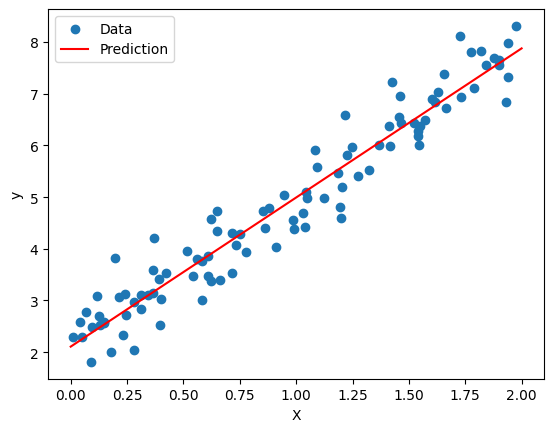

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Generate sample data: y = 3x + 2 + noise
np.random.seed(42)
X = 2 * np.random.rand(100, 1)
y = 3 * X.flatten() + 2 + np.random.randn(100) * 0.5

# Initialize and train your model
model = LinearRegressionScratch(learning_rate=0.1, epochs=1000, verbose=True)
model.fit(X, y)

# Predictions
X_test = np.array([[0], [1], [2]])
predictions = model.predict(X_test)

print("Predictions for X_test:", predictions)

# Plot data and prediction line
plt.scatter(X, y, label='Data')
plt.plot(X_test, predictions, color='red', label='Prediction')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()


In [ ]:
class LogisticRegressionScratch:
  def __init__(self,learning_rate = 0.001, epochs = 1000,verbose = False):
    self.learning_rate = learning_rate
    self.epochs = epochs
    self.verbose = verbose
    self.weights = None
    self.bias = None

  def sigmoid(self,X):
    return 1/(1+np.exp(-X))

  def fit(self,X,y):
    num_samples = X.shape[0]
    num_features = X.shape[1]
    self.weights = np.random.randn(num_features)
    self.bias = 0

    for epoch in range(self.epochs):
      z = X.dot(self.weights) + self.bias
      y_preds = self.sigmoid(z)
      dw = 1/num_samples * X.T.dot(y_preds-y)
      db = 1/num_samples * np.sum(y_preds-y)

      self.weights -= dw * self.learning_rate
      self.bias -= db * self.learning_rate

      if self.verbose and epoch % 100 == 0:
        epsilon = 1e-15
        loss = - 1 / num_samples * np.sum(y * np.log(y_preds+epsilon) + (1-y) * np.log(1-y_preds+epsilon))
        print(f"epoch {epoch} loss = {loss}")

  def predict(self,X):
    z = X.dot(self.weights) + self.bias
    y_preds = self.sigmoid(z)
    return (y_preds>=0.5).astype(int)

  def accuracy(self,X,y):
    y_preds = self.predict(X)
    return np.mean(y_preds == y)


In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Generate dummy binary classification data
X, y = make_classification(n_samples=500, n_features=5, n_informative=3, n_redundant=0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegressionScratch(learning_rate=0.1, epochs=1000,verbose=True)
model.fit(X_train, y_train)
print("Train Accuracy:", model.accuracy(X_train, y_train))
print("Test Accuracy:", model.accuracy(X_test, y_test))

epoch 0 loss = 1.2280363329325863
epoch 100 loss = 0.31134343648661256
epoch 200 loss = 0.29804721038330917
epoch 300 loss = 0.2942835737137249
epoch 400 loss = 0.29286779622857684
epoch 500 loss = 0.29226968728198666
epoch 600 loss = 0.2920005917412164
epoch 700 loss = 0.29187483679695864
epoch 800 loss = 0.29181462328936186
epoch 900 loss = 0.291785323903164
Train Accuracy: 0.885
Test Accuracy: 0.9


In [ ]:
class Node:
  def __init__(self, feature_index = None, threshhold=None,left=None,right=None,value=None):
    self.feature_index = feature_index
    self.threshhold=threshhold
    self.left = left
    self.right = right
    self.value = value

class DecisionTreeScratch:
  def __init__(self, max_depth = 5,min_samples_split = 5):
    self.root = None
    self.max_depth = max_depth
    self.min_samples_split = min_samples_split

  def fit(self,X,y):
    self.root = self.build_tree(X,y,depth = 0)

  def build_tree(self, X, y, depth):
      if len(X) <= self.min_samples_split or len(np.unique(y)) == 1 or depth == self.max_depth:
          leaf_value = self._most_common(y)
          return Node(value=leaf_value)

      parent_entropy = self._entropy(y)

      best_ig = -float('inf')
      best_feature_index = None
      best_threshold = None
      best_left_X, best_left_y = None, None
      best_right_X, best_right_y = None, None

      for feature_index in range(X.shape[1]):
          feature_values = np.sort(np.unique(X[:, feature_index])) #gets all unique features in this current feature and sorts them
          thresholds = (feature_values[:-1] + feature_values[1:]) / 2 #threshholds are between each unique point

          for threshold in thresholds:
              left_mask = X[:, feature_index] <= threshold #splits X into groups based on threshhold
              right_mask = X[:, feature_index] > threshold
              X_left, y_left = X[left_mask], y[left_mask]
              X_right, y_right = X[right_mask], y[right_mask]

              if len(y_left) == 0 or len(y_right) == 0:
                  continue  # Skip invalid splits

              weighted_entropy = (len(y_left) / len(y)) * self._entropy(y_left) + (len(y_right) / len(y)) * self._entropy(y_right)
              information_gain = parent_entropy - weighted_entropy

              if information_gain > best_ig:
                  best_ig = information_gain
                  best_feature_index = feature_index
                  best_threshold = threshold
                  best_left_X, best_left_y = X_left, y_left
                  best_right_X, best_right_y = X_right, y_right

      # If no good split found, make a leaf
      if best_ig == -float('inf'):
          leaf_value = self._most_common(y)
          return Node(value=leaf_value)

      # Recursively build left and right subtrees
      left_child = self.build_tree(best_left_X, best_left_y, depth + 1)
      right_child = self.build_tree(best_right_X, best_right_y, depth + 1)

      # Return a decision node
      return Node(feature_index=best_feature_index, threshhold=best_threshold, left=left_child, right=right_child)




  def predict(self,X):
    return np.array([self._traverse_tree(x, self.root) for x in X])


  def _traverse_tree(self, x, node):
      if node.value is not None:
          return node.value

      feature_value = x[node.feature_index]
      if feature_value <= node.threshhold:
        return self._traverse_tree(x,node.left)
      else:
        return self._traverse_tree(x,node.right)



  def _entropy(self,y):
    values,counts = np.unique(y,return_counts=True)
    probabilities = counts/len(y)
    entropy = - np.sum(probabilities * np.log2(probabilities))
    return entropy

  def _most_common(self,y):
    value,counts = np.unique(y,return_counts=True)
    return value[np.argmax(counts)]

  def score(self,X,y):
    y_preds = self.predict(X)
    return np.mean(y_preds==y)



In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Load Iris data
iris = load_iris()
X, y = iris.data, iris.target


# For simplicity, let's do a binary classification: class 0 vs not 0
y_binary = (y == 0).astype(int)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.3, random_state=42)


tree = DecisionTreeScratch(max_depth=3, min_samples_split=5)
tree.fit(X_train, y_train)

print("Train accuracy:", tree.score(X_train, y_train))
print("Test accuracy:", tree.score(X_test, y_test))


Train accuracy: 1.0
Test accuracy: 1.0


In [ ]:
class RandomForestScratch: #literally just a bunch of decision trees predict on it then get majority vote XD
  def __init__(self, max_depth = 5,min_samples_split = 5,num_trees=10):
    self.max_depth = max_depth
    self.min_samples_split = min_samples_split
    self.num_trees = num_trees
    self.trees = []


  def _bootstrap_samples(self,X,y): #get samples using replacement
    num_samples = X.shape[0]
    indices = np.random.choice(num_samples,size=num_samples,replace=True)
    X_bootstrap = X[indices]
    y_bootstrap = y[indices]
    return X_bootstrap,y_bootstrap

  def fit(self,X,y):
    for i in range(self.num_trees):
      X_bootstrap,y_bootstrap = self._bootstrap_samples(X,y)
      new_tree = DecisionTreeScratch(self.max_depth,self.min_samples_split)
      new_tree.fit(X_bootstrap,y_bootstrap)
      self.trees.append(new_tree)

  def predict(self,X):
    all_preds = []

    for tree in self.trees:
        preds = tree.predict(X)
        all_preds.append(preds)

    all_preds = np.array(all_preds)
    all_preds = all_preds.T
    final_preds = [np.bincount(row).argmax() for row in all_preds]
    return np.array(final_preds)





In [ ]:
import numpy as np


# Class 0: centered at (0,0)
X_class0 = np.random.randn(50, 2) * 0.5 + np.array([0, 0])

# Class 1: centered at (2,2)
X_class1 = np.random.randn(50, 2) * 0.5 + np.array([2, 2])

X_train = np.vstack((X_class0, X_class1))
y_train = np.array([0]*50 + [1]*50)

indices = np.arange(len(y_train))
np.random.shuffle(indices)
X_train = X_train[indices]
y_train = y_train[indices]

X_test = np.array([
    [0, 0],    # close to class 0
    [2, 2],    # close to class 1
    [1, 1],    # in between
    [3, 3],    # far class 1
    [-1, -1]   # far class 0
])

# Create, train and predict
rf = RandomForestScratch(max_depth=5, min_samples_split=2, num_trees=10)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Test predictions:", y_pred)


Test predictions: [0 1 1 1 0]


In [ ]:
from collections import Counter


class knnScratch:
  def __init__(self,k):
    self.k = k

  def fit(self,X,y):
    self.X_train = X
    self.y_train = y

  def predict(self, x):
      diff = self.X_train - x  # broadcast subtraction
      distances = np.sum(diff ** 2, axis=1)  # squared Euclidean distances for all training samples
      k_indices = np.argsort(distances)[:self.k]

      # Get the labels of those k nearest neighbors
      k_labels = self.y_train[k_indices]

      majority_label = Counter(k_labels).most_common(1)[0][0]
      return majority_label


  def predict_batch(self, X):
      return [self.predict(x) for x in X]

In [ ]:
import numpy as np

X_train = np.array([[1,2], [2,3], [3,4], [5,5]])
y_train = np.array([0, 0, 1, 1])

model = knnScratch(k=3)
model.fit(X_train, y_train)

X_test = np.array([[2,2], [4,4]])
predictions = model.predict_batch(X_test)
print(predictions)


[np.int64(0), np.int64(1)]


In [9]:
class ActivationFunction:
  def forward(self,x):
    raise NotImplementedError

  def derivative(self,x):
    raise NotImplementedError

#==============================activation functions================================#

class ReLU(ActivationFunction):
    def forward(self, x):
        return np.maximum(0, x)

    def derivative(self, x):
        return (x > 0).astype(float)

class Sigmoid(ActivationFunction):
    def forward(self, x):
        return 1 / (1 + np.exp(-x))

    def derivative(self, x):
        sig = self.forward(x)
        return sig * (1 - sig)

#==============================NN scratch =======================================#
class NeuralNetScratch:
  def __init__ (self, layer_sizes, activations, learning_rate = 0.001):
    self.learning_rate = learning_rate
    self.layers = len(layer_sizes)
    self.layer_sizes = layer_sizes
    self.weights = []
    self.biases = []
    self.activations = activations #initializing activations from activations lists

    for i in range(self.layers-1):
      weight = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2 / layer_sizes[i])
      bias = np.zeros((1, layer_sizes[i+1]))
      self.weights.append(weight)
      self.biases.append(bias)


  def forward(self,X):
    activations = [X]
    z_values = []

    input_to_next = X

    for i in range(self.layers - 1):
      z = np.dot(input_to_next, self.weights[i]) + self.biases[i]
      z_values.append(z)

      if i == self.layers-2: #last layer
        a = z
      else:
        a = self.activations[i].forward(z)

      activations.append(a)
      input_to_next = a

    return activations, z_values


  def backward(self, activations,z_values, y_true):
      grads_w = [None] * (self.layers - 1) #
      grads_b = [None] * (self.layers - 1)

      delta = (activations[-1] - y_true)

      for i in reversed(range(self.layers - 1)):
          a_prev = activations[i]
          grads_w[i] = np.dot(a_prev.T, delta) / y_true.shape[0]
          grads_b[i] = np.mean(delta, axis=0, keepdims=True)

          if i > 0:
            derivative = self.activations[i-1].derivative(z_values[i-1])
            delta = np.dot(delta, self.weights[i].T) * derivative

      for i in range(self.layers - 1):
          self.weights[i] -= self.learning_rate * grads_w[i]
          self.biases[i] -= self.learning_rate * grads_b[i]

  def train(self, X_train, y_train, epochs=100, batch_size=32):
    n_samples = X_train.shape[0]

    for epoch in range(epochs):
      permutation = np.random.permutation(n_samples)
      X_shuffled = X_train[permutation]
      y_shuffled = y_train[permutation]

    epoch_loss = 0

    for i in range(0, n_samples, batch_size):
      X_batch = X_shuffled[i:i + batch_size]
      y_batch = y_shuffled[i:i + batch_size]

      activations, z_values = self.forward(X_batch)
      output = activations[-1]

      loss = np.mean((output - y_batch) ** 2)
      epoch_loss += loss * X_batch.shape[0]

      self.backward(activations, z_values, y_batch)

      epoch_loss /= n_samples
      print(f"Epoch {i + 1}/{epochs}, Loss: {epoch_loss:.4f}")


In [10]:
import numpy as np

# Set seed and generate dataset
np.random.seed(42)
X_train = np.random.rand(100, 1)
y_train = 2 * X_train + 1 + 0.1 * np.random.randn(100, 1)

# Initialize and train neural net
nn = NeuralNetScratch([1, 10, 1], activations=[ReLU()], learning_rate=0.1)
nn.train(X_train, y_train, epochs=100, batch_size=10)

# Make predictions
X_test = np.array([[0.5], [1.5], [3.0]])
predictions = nn.forward(X_test)[0][-1]
print("Predictions:")
print(predictions)


Epoch 1/100, Loss: 2.3481
Epoch 11/100, Loss: 0.0904
Epoch 21/100, Loss: 0.0677
Epoch 31/100, Loss: 0.0158
Epoch 41/100, Loss: 0.0171
Epoch 51/100, Loss: 0.0148
Epoch 61/100, Loss: 0.0221
Epoch 71/100, Loss: 0.0134
Epoch 81/100, Loss: 0.0150
Epoch 91/100, Loss: 0.0168
Predictions:
[[2.00426676]
 [5.04704627]
 [9.61121553]]
